In [16]:
%reset -f
from wavhandler import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [19]:
dataset1 = Dataset('Pcfruit')
dataset1.read(data='D. suzukii')

Data: D. suzukii.
Read 8567 filenames in 0.08 seconds.
Loaded data into matrix in 1.00 seconds.


### Example signal

In [20]:
# dataset1.X.iloc[np.random.randint(0,dataset1.X.shape[0]),:].plot(figsize=(25,8), ylim=(-.2,.2))

# 1. Comparing the raw time series within one insect group

### - They all have the same trigger point, BUT it might be a false trigger, plus it could be 2 insects instead of 1 (FIND FALSE TRIGGERS - e.g. std of some miliseconds after trigger)

### Finding the trigger point

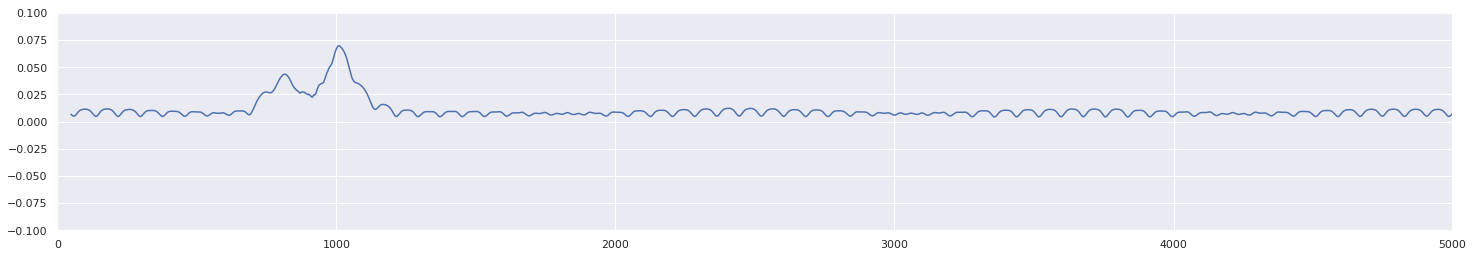

In [27]:
window = 50

rdm = np.random.randint(0,dataset1.X.shape[0])
sig = dataset1.X.iloc[rdm,:]
# square of the waveform , averaged over time window, sqrt 
rdm_sig = sig.pow(2).rolling(window).mean().pow(1/2)
rdm_sig.plot(figsize=(25,4), ylim=(-.1,.1))

In [14]:
# values near 1000
dataset1.X.apply(lambda x: x[999], axis=1).describe()

count    13619.000000
mean        -0.008619
std          0.036852
min         -0.976990
25%         -0.006897
50%         -0.004425
75%          0.005829
max          0.955994
dtype: float64

### Finding the index of max RMS value for all signals (which should be the trigger point or close to it)

In [15]:
rms_idx = dataset1.X.apply(lambda x: x.pow(2).rolling(window).mean().pow(1/2).idxmax(), axis=1).describe()
rms_idx

count    13619.000000
mean      1375.166018
std        962.868851
min         49.000000
25%        993.000000
50%       1027.000000
75%       1089.000000
max       4999.000000
dtype: float64

### Calculating statistics around the trigger point

count    400.000000
mean      -0.021722
std        0.030708
min       -0.087921
25%       -0.031601
50%       -0.007996
75%        0.001053
max        0.013336
Name: 3040, dtype: float64

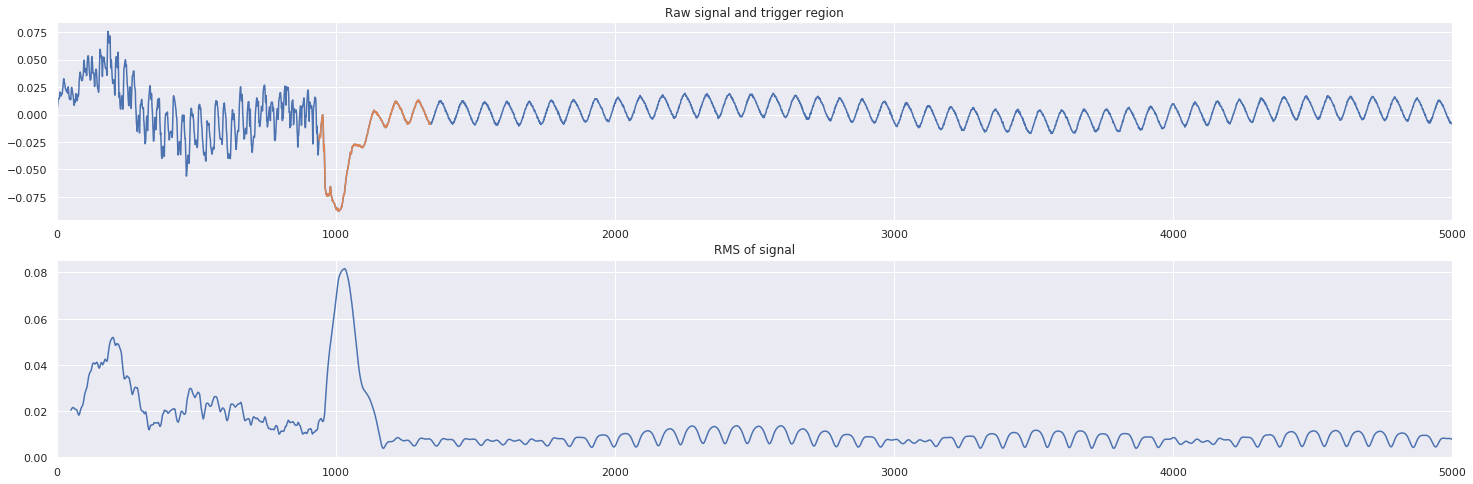

In [285]:
rdm = np.random.randint(0,dataset1.X.shape[0])
idx = int(rms_idx['50%']) # The 50-percentile found above
sig = dataset1.X.iloc[rdm,:] # Getting a random signal
plt.figure()
plt.subplot(2,1,1)
plt.plot(sig) # plotting the random signal
sig_trig = sig.iloc[idx-100:idx+300] # overlaying selected points around trigger
sig_trig.plot(figsize=(25,8), title='Raw signal and trigger region')
plt.subplot(2,1,2)
sig.pow(2).rolling(window).mean().pow(1/2).plot(title='RMS of signal')

sig_trig.describe()

### Performing PCA on signals (around trigger)

In [286]:
df_trig = dataset1.X.apply(lambda x: x.iloc[idx-15:idx+300], axis=1)
df_trig.shape

(6423, 315)

Explained Variance with 2 components: 0.76


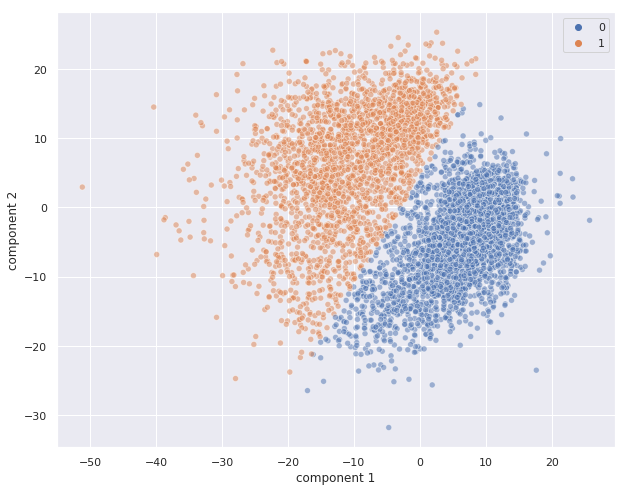

In [322]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

X = df_trig.values
y= pd.Series(np.ones((6423,)))

X_std = scale(X, with_std=True) # standardization of data

ncomps=2
setting = 'pca'
pca = PCA(n_components=ncomps) 
X_final = pca.fit_transform(X_std)
print("Explained Variance with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

d = pd.DataFrame(X_final)
d['rowmean'] = d.mean(axis=1)
X_final = d[d['rowmean'] < 50][[0,1]].values # Removing outliers

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_final)
yk = kmeans.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.5, legend='full', hue=yk) # KMEANS clustering
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

### PCA scores

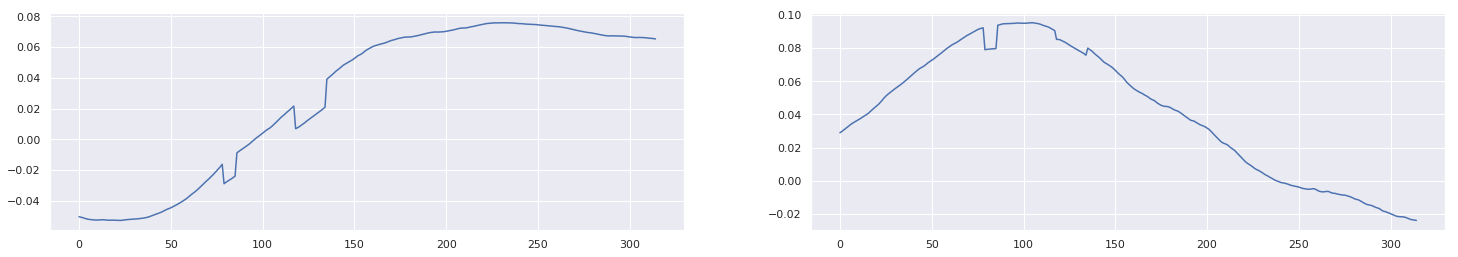

In [323]:
plt.figure(figsize=(25,4))
plt.subplot(1,2,1); plt.plot(pca.components_[0,:]);
plt.subplot(1,2,2); plt.plot(pca.components_[1,:]);

In [289]:
# loadings
# zz = pca.components_.T * np.sqrt(pca.explained_variance_)
# plt.figure(figsize=(25,4))
# plt.subplot(1,2,1); plt.plot(zz[:,0]);
# plt.subplot(1,2,2); plt.plot(zz[:,1]);

### Plotting Outlier signals

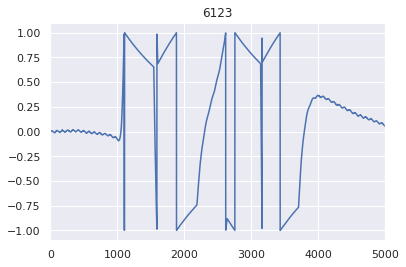

In [337]:
import random
outlr_choice = random.choice(d[d['rowmean'] > 50][[0,1]].index.tolist())
dataset1.X.iloc[outlr_choice,:].plot(title=str(outlr_choice))

### Creating a "clean" dataframe without the outliers

In [338]:
inds = d[d['rowmean'] < 50][[0,1]].index
df_clean1 = pd.DataFrame(X[inds,:])
df_clean1['y'] = y[inds]
df_clean1['kmeans'] = kmeans.labels_
df_clean1.head()

,0,1,2,3,4,5,6,7,8,9,...,307,308,309,310,311,312,313,314,y,kmeans
0,0.006439,0.023010,0.061829,0.085175,0.082306,0.073486,0.059357,0.044403,0.031036,0.017853,...,-0.029724,-0.029114,-0.029907,-0.032196,-0.030273,-0.029358,-0.030396,-0.028839,1.0,1
1,-0.037354,-0.036682,-0.036835,-0.034973,-0.033417,-0.032349,-0.031616,-0.031036,-0.029602,-0.028198,...,0.016327,0.017639,0.017395,0.017334,0.022583,0.024414,0.025909,0.028168,1.0,0
2,0.063873,0.075043,0.079895,0.080353,0.084808,0.087494,0.087860,0.087250,0.086365,0.083923,...,0.029205,0.023163,0.014160,0.006653,0.001923,-0.001465,-0.001862,-0.001953,1.0,1
3,-0.050903,-0.049622,-0.050323,-0.050903,-0.052826,-0.055176,-0.057037,-0.057648,-0.060822,-0.064880,...,0.026733,0.028503,0.028381,0.027679,0.028564,0.028778,0.029694,0.028625,1.0,0
4,-0.048309,-0.048798,-0.047821,-0.047516,-0.047455,-0.046783,-0.047729,-0.047455,-0.047150,-0.047424,...,0.018707,0.019745,0.021149,0.020447,0.021240,0.021149,0.020752,0.020294,1.0,0


In [339]:
y_std = df_clean1.iloc[:,:-2].std(axis=1)
y_std = y_std > 0.04
y_std.shape

(6419,)

### Correlation matrix for points around trigger

In [340]:
corr_trig = df_clean1.iloc[:,:-2].corr(method='pearson')

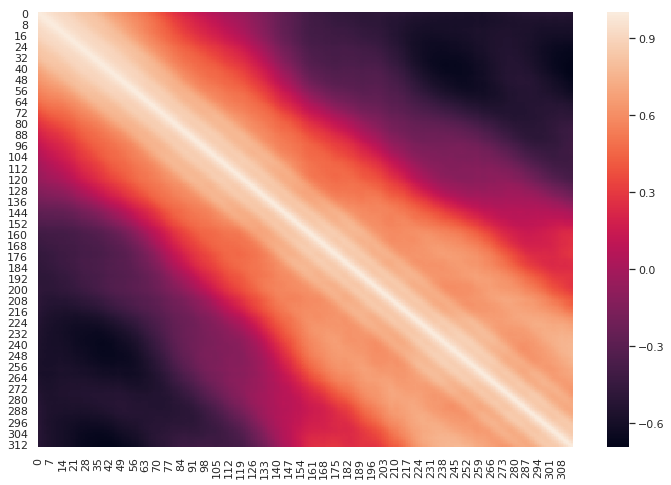

In [341]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_trig)
# high correlations with points that are close, 
# the distance of highly correlated points increases 
# presumably since the insect has already exited

### Analyzing the 2 kmeans clusters

In [295]:
df_0 = df_clean1[df_clean1['kmeans']==0].drop(['y','kmeans'], axis=1)
df_1 = df_clean1[df_clean1['kmeans']==1].drop(['y','kmeans'], axis=1)
print("CLUSTER 0 SHAPE: {}".format(df_0.shape))
print("CLUSTER 1 SHAPE: {}".format(df_1.shape))

CLUSTER 0 SHAPE: (3976, 315)
CLUSTER 1 SHAPE: (2443, 315)


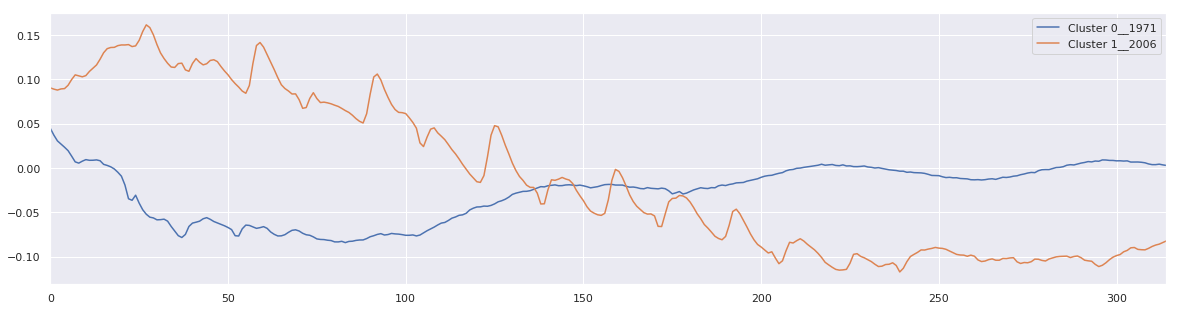

In [296]:
rdm0 = np.random.randint(0, df_0.shape[0])
rdm1 = np.random.randint(0, df_1.shape[0])

df_0.iloc[rdm0,:].plot(figsize=(20,5))
df_1.iloc[rdm1,:].plot(figsize=(20,5))
plt.legend(['Cluster 0__'+str(rdm0),'Cluster 1__'+str(rdm1)])

In [297]:
# Cluster 0 description 
df_0.T.describe().median(axis=1)

count    315.000000
mean      -0.020522
std        0.026958
min       -0.083084
25%       -0.037743
50%       -0.012421
75%        0.000412
max        0.019012
dtype: float64

In [298]:
# Cluster 1 description
df_1.T.describe().median(axis=1)

count    315.000000
mean      -0.006956
std        0.042941
min       -0.077789
25%       -0.043060
50%       -0.016327
75%        0.026413
max        0.093628
dtype: float64

### Examining Cluster 0

In [299]:
rdm = np.random.randint(0, df_0.shape[0])
# df_0.iloc[rdm,:].plot(ylim=(-.15,.15))
# plt.plot(df_1.index.tolist())
dataset1.get_sensor_features()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd21bbddd8>,
      dtype=object)

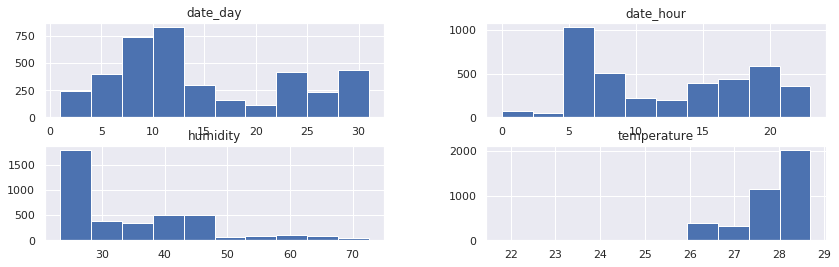

In [300]:
# selecting all signals that belong to cluster 0 by index
dataset1.df_features.reindex(df_0.index).dropna().hist(figsize=(14,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd1ca9b048>,
      dtype=object)

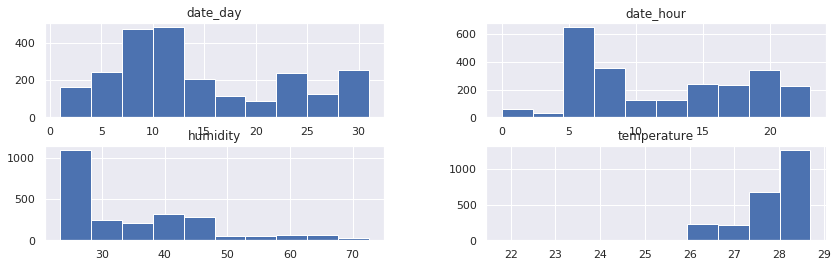

In [301]:
# selecting all signals that belong to cluster 1 by index
dataset1.df_features.reindex(df_1.index).dropna().hist(figsize=(14,4))

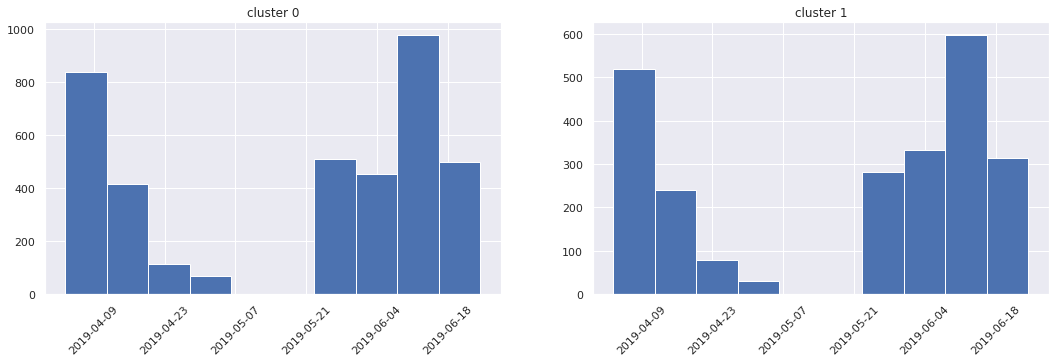

In [302]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1); plt.title('cluster 0')
dataset1.df_features.reindex(df_0.index).dropna().date.hist(xrot=45)
plt.subplot(1,2,2); plt.title('cluster 1')
dataset1.df_features.reindex(df_1.index).dropna().date.hist(xrot=45)

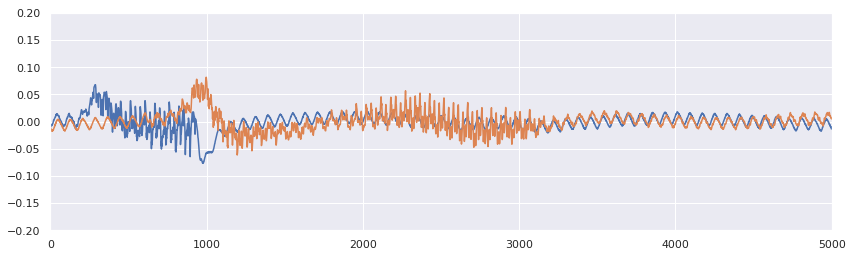

In [372]:
dataset1.X.reindex(df_0.index).dropna().iloc[np.random.randint(0,2000),:].plot(figsize=(14,4), ylim=(-.2,.2))
dataset1.X.reindex(df_1.index).dropna().iloc[np.random.randint(0,2000),:].plot(figsize=(14,4), ylim=(-.2,.2))

## - The flying time might vary depending on the route an insect takes (straight line / doing circles etc.) (DEFINE AND FIND MEAN FLYING TIME e.g. rolling window of mean/std)

(693,)

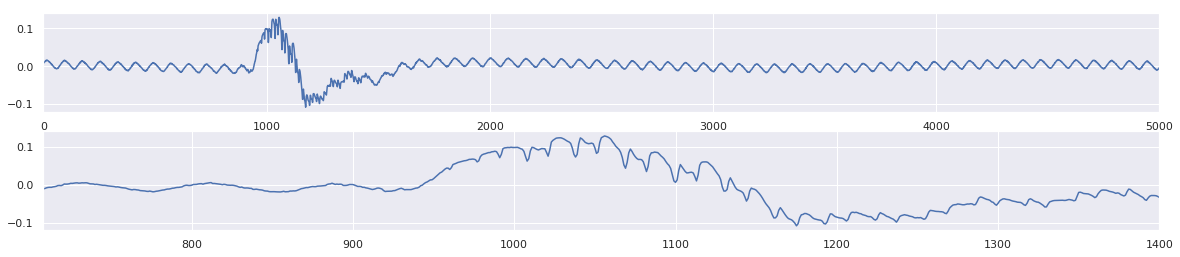

In [319]:
rdm = np.random.randint(0, dataset1.X.shape[0])
sig = dataset1.X.iloc[rdm,:]
plt.subplot(2,1,1)
sig.plot(figsize=(20,4))
plt.subplot(2,1,2)
sigc = crop_signal(sig.values, window=100,  intens_threshold=0.01)
sigc.plot()
sigc.shape

In [625]:
import more_itertools as mit
from tqdm import tqdm

window=50 
intens_threshold=0.007 
nflights = []
for rdm in tqdm(range(len(dataset1.X))):
    # rdm = np.random.randint(0, dataset1.X.shape[0])
    sigseries = dataset1.X.iloc[rdm,:]
#     sigseries.plot()

    sig_std = sigseries.rolling(window).std() # rolling average

    sig_flights = sigseries[sig_std[sig_std > intens_threshold].index]
    # sig_flights.plot()

    iterable = sig_flights.index.tolist()
    groups = [list(group) for group in mit.consecutive_groups(iterable)]

    idx = np.argmax([sigseries.loc[groups[i]].var() for i in range(len(groups))])
    # sigseries.loc[groups[idx]].plot()
    flight_len = len(sigseries.loc[groups[idx]])
    nflights.append(flight_len)

    # plt.ylim((-.1,.1))

100%|██████████| 6423/6423 [05:49<00:00, 24.05it/s]


In [626]:
pd.Series(flights).median()

318.0

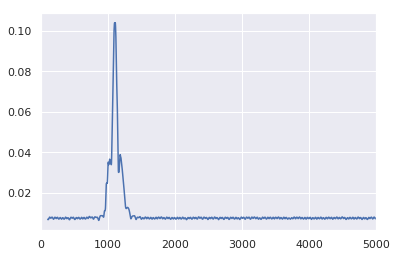

In [630]:
sig.rolling(100).std().plot()